In [92]:
#HEADER
import os
import copy
import os
import random
import re
import shutil
import torch
import numpy as np
from armor_py.options import args_parser
from prettytable import PrettyTable
from armor_py.utils import del_tensor_element, fix_random
import matplotlib.pyplot as plt
import wandb
import itertools
import io
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})




def wandb_init(args):
        run = wandb.init(reinit=True, project="Plots",
                         name="dataset" + str(args.dataset),
                         config=args)
        return run


def extract_list_ASR(file):
    dictionary={}
    with open(file, "r", encoding="utf-8") as f:
            if (file.split("iterrround_",1)[1][:3]=="1.0"):
                attack='FGSM'
            elif(file.split("projected_",1)[1][:3]=="1.0"):
                attack= "PGD"
            else:
                attack="BIM"

            
            if ("Global" in file):
                attack += "+CRN"
                loaded_models= int(float(file.split("loadedmodels_",1)[1][:4]))
                if (loaded_models==5):
                    attack +="5"
                # elif (loaded_models==5):
                #     attack +="5"
                else:
                      attack +="10"

            dictionary['attack']=attack
          
            eps=file.split("eps_",1)[1][0:4]
            dictionary['eps']=eps
            step=file.split("step_",1)[1][:5]
            dictionary['step']=step


            for num,line in enumerate ( f):
                if (num==1) :
                    selfasr=line[6:12]
                    dictionary['selfasr']=selfasr
                    others=line[-21:-15]
                    dictionary['others_asr']=others
    return dictionary


def list_extractor(input):
    if (metric=='ASR'):
       output= extract_list_ASR(input)

    elif (metric=='time'):
         output= extract_list_time(input)

    elif (metri=="AATR"):
        output= extract_list_AATR(input)
    return output

def megalist(path):
    megalist=[]
    for file in os.listdir(path):
        list=list_extractor( path+'/'+file)
        megalist.append(list)
    return megalist


def extract_list_time(file):
    dictionary={}
    with open(file, "r", encoding="utf-8") as f:
            if (file.split("iterrround_",1)[1][:3]=="1.0"):
                attack='FGSM'
            elif(file.split("projected_",1)[1][:3]=="1.0"):
                attack= "PGD"
            else:
                attack="BIM"

            
            if ("Global" in file):
                attack += "+CRN"
                loaded_models= int(float(file.split("loadedmodels_",1)[1][:4]))
                if (loaded_models==5):
                    attack +="5"
                # elif (loaded_models==5):
                #     attack +="5"
                else:
                      attack +="10"

            dictionary['attack']=attack
          
            eps=file.split("eps_",1)[1][0:4]
            dictionary['eps']=eps
            step=file.split("step_",1)[1][:5]
            dictionary['step']=step
            iterround=int(float(file.split("iterrround_",1)[1][:4]))
            dictionary['iterrround']=iterround
            for num,line in enumerate ( f):
                if 'time' in line:
                   dictionary['time']=("{:.3f}".format(float(line.split("time:",1)[1])))

                if 'ASR' in line:
                    dictionary['asr']=("{:.3f}".format(float(line.split("ASR:",1)[1])))

    return dictionary

def draw_tables_ASR():
    list=megalist(path)
    x=PrettyTable()
    print(list)
    columns_to_show= ["attack", "eps", "selfasr", "step","others_asr"]
    x.field_names =columns_to_show
    for item in list:
            if (not "BIM" in item['attack']):
                    items_to_show = [item[columns] for columns in columns_to_show]
                    x.add_row(items_to_show)
    print((x.get_string(sortby="attack")))




def draw_tables_AATR():
    list=megalist(path_aatr)
    x=PrettyTable()
    columns_to_show= ["attack", "AATR","eps"]
    x.field_names =columns_to_show
    for item in list:
            if (not ("BIM" in item['attack']) and item['step']=='0.002' and item['eps'] in['0.03'] ):
                    items_to_show = [item[columns] for columns in columns_to_show]
                    x.add_row(items_to_show)
    print((x.get_string(sortby="attack")))
 
def plot_graphs():
    list=megalist(path)
    eps_step_list= [0.001,0.002,0.003,0.005,0.007,0.010,0.015,0.020]

    pgd_list=([item for item in list if (not("BIM"  in item['attack']) and  ( item['eps']=='0.03'))])
    pgd_list = [
    {
        key: float(value.strip('%\t')) if key in ('selfasr', 'others_asr') else value
        for key, value in item.items()
    }
    for item in pgd_list
]
    f1=plt.figure()
    f2=plt.figure()
    ax1 = f1.add_subplot(111)
    ax2 = f2.add_subplot(111)
    marker = itertools.cycle(('v', '+', 'd', 'x', '*')) 

    # for i,attack_method in enumerate ( ["PGD+CRN10","PGD+CRN5","PGD"]):
    for i,attack_method in enumerate ( ["PGD"]):

        markerlist=["D","o","v"]
        BIM_others,BIM_self,BIM_step=[],[],[]
        for item in pgd_list:
            try:
                if (item["attack"] ==attack_method):
                    BIM_self.append(float(item["selfasr"][:-1]))
                    BIM_others.append(float(item["others_asr"][:-1]))
                    BIM_step.append(item["step"])
            except:
                pass
    
        ax1.plot(BIM_step,BIM_others,marker=next(marker),label=attack_method )
        ax2.plot(BIM_step,BIM_self,marker=next(marker),label=attack_method)

    ax1.set_title(dataset)
    ax1.set_xlabel("EPS step")
    ax1.set_ylabel("ASR(%) Benign")
    ax1.set_ylim(bottom=0)

    ax2.set_title(dataset)
    ax2.set_xlabel("EPS step")
    ax2.set_ylabel("ASR(%) Adversary")
    ax2.set_ylim(bottom=0)

    # ax1.legend(loc=legend_location)
    # ax2.legend(loc=legend_location)

    f1.savefig('./plots/'+dataset+'_ASR_EPS_steps.eps')
    f1.savefig('./plots/'+dataset+'_ASR_EPS_steps.png')


    buf = io.BytesIO()
    f2.savefig('./plots/'+dataset+'_others_EPS_steps.eps')
    f2.savefig('./plots/'+dataset+'_others_EPS_steps.png')
 
def draw_tables_time():

    list=megalist(path_time)
    x=PrettyTable()
    print(list)
    columns_to_show= ["attack", "asr", "iterrround",'time']
    x.field_names =columns_to_show
    for item in list:
            if (not "BIM" in item['attack']):
                    items_to_show = [item[columns] for columns in columns_to_show]
                    x.add_row(items_to_show)
    print((x.get_string(sortby="attack")))



import matplotlib.pyplot as plt
import itertools
import io


def plot_graphs_eps(dataset, path):

    list = megalist(path)
    eps_list = [0.01, 0.03, 0.05, 0.07]
    pgd_list = ([item for item in list if (not("BIM" in item['attack'] and item['step'] == '0.002'))])
    pgd_list = [
        {
            key: float(value.strip('%\t')) if key in ('selfasr', 'others_asr') else value
            for key, value in item.items()
        }
        for item in pgd_list
    ]

    f1 = plt.figure()
    f2 = plt.figure()
    ax1 = f1.add_subplot(111)
    ax2 = f2.add_subplot(111)
    marker = itertools.cycle(('v', '+', 'd', 'x', '*'))
    colors = itertools.cycle(('red', 'blue', 'green', 'purple', 'orange'))

    title = dataset if dataset != "MRI" else "Meningioma"
    
    for i, attack_method in enumerate(["PGD", "FGSM"]):

        BIM_others, BIM_self, BIM_step = [], [], []
        for item in pgd_list:
            if (item["attack"] == attack_method and item["others_asr"] > 0 and item['step'] == '0.002'):

                BIM_others.append((item["others_asr"]))
                BIM_self.append((item["selfasr"]))
                BIM_step.append(item["eps"])

        current_color = next(colors)
        ax1.scatter(BIM_step, BIM_others, marker=next(marker), label=attack_method, color=current_color)
        ax1.plot(BIM_step, BIM_others, color=current_color, linestyle='--')
        ax2.scatter(BIM_step, BIM_self, marker=next(marker), label=attack_method, color=current_color)
        ax2.plot(BIM_step, BIM_self, color=current_color, linestyle='--')

    ax1.set_title(title)
    ax1.set_xlabel(r"$\epsilon$")
    ax1.set_ylabel("ASR(%) Benign")
    ax1.set_ylim(bottom=0)

    ax2.set_title(title)
    ax2.set_xlabel(r"$\epsilon$")
    ax2.set_ylabel("ASR(%) Adversary")
    ax2.set_ylim(bottom=0)
    if (dataset=="MRI"):
        ax1.legend()
        ax2.legend()
    # ax1.legend(loc=legend_location)
    # ax2.legend(loc=legend_location)

    buf = io.BytesIO()
    f1.savefig('./plots/' + dataset + '_ASR_EPS_v2.eps')

    f2.savefig('./plots/' + dataset + '_others_EPS_v2.eps')
    return f1, f2


def extract_list_AATR(file):
    dictionary={}
    with open(file, "r", encoding="utf-8") as f:
            if (file.split("iterrround_",1)[1][:3]=="1.0"):
                attack='FGSM'
            elif(file.split("projected_",1)[1][:3]=="1.0"):
                attack= "PGD"
            else:
                attack="BIM"

            
            if ("Global" in file):
                attack += "+CRN"
                # if(args.dataset=='Pathology'):
                #   loaded_models= int(float(file.split("loadedmodels_",1)[1][:4]))
                # else:
                loaded_models= int(float(file.split("loadedmodels_",1)[1][0:4]))

            
                if (loaded_models==10):
                    attack +="10"
                elif (loaded_models==5):
                    attack +="5"
                elif (loaded_models==0):
                    pass                #is not Global
                else:
                    raise "Unknown number of models"
               

            dictionary['attack']=attack
   
            eps=file.split("eps_",1)[1][0:4]
            dictionary['eps']=eps
            step=file.split("step_",1)[1][:5]
            dictionary['step']=step
            for num,line in enumerate ( f):
                if (num==1):
                    stripped = line.split('\t', 1)[1]
                    dictionary['AATR']=stripped

            
    return dictionary


 

def plot_graphs_alignment():
    dataset="/"+args.dataset
    path=r'./by_client/dp' + dataset +r'\result_out'
    path_aatr=r'./by_client/dp'+dataset+r'\ATR_pic\out'
    path_time=r'./by_client/dp' +dataset +r'\client_num_3\Attack_fixed\Client_noise_only\attack_time'

def path_finder(dataset):
    
    
   path=r"./by_client/dp/" + dataset +r"/result_out"
   path_aatr=r"./by_client/dp/"+dataset+r'/ATR_pic/out'
   path_time=r"./by_client/dp/" +dataset +r"/client_num_3/Attack_fixed/Client_resnoise_only/attack_time"
   return path,path_aatr,path_time
# if __name__ == '__main__':

#     args = args_parser()
#     device = torch.device("cuda:{}".format(args.cuda))
#     args.device = device
#     dataset="/"+args.dataset
    
#     path=r'.\by_client\dp' + dataset +r'\result_out'
#     path_aatr=r'.\by_client\dp'+dataset+r'\ATR_pic\out'
#     path_time=r'.\by_client\dp' +dataset +r'\client_num_3\Attack_fixed\Client_resnoise_only\attack_time'
#     fix_random(0)
#     legend_location='lower right'
#     dataset=args.dataset
#     if (args.draw_tables=='ASR'):
#                 print("drawing tables..")
#                 draw_tables_ASR()
#     if (args.plot_graphs=="ASR"):
#                 print("plotting graphs...")
#                 plot_graphs()
#                 plot_graphs_eps()
#     if (args.draw_tables=='AATR'):
#                 draw_tables_AATR()
#     if (args.draw_tables=='time'):
#                 print('drawing table time..')
#                 draw_tables_time()
#     if (args.draw_tables=='alignment'):
#                 print('drawing alignmment tables..')
#                 plot_graphs_alignment()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

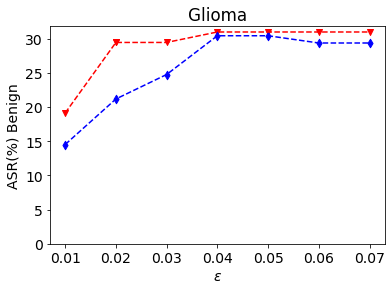

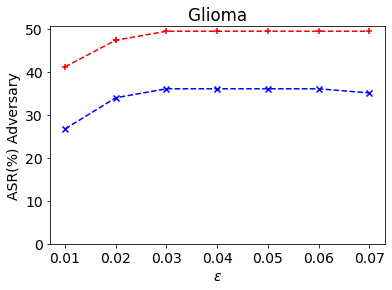

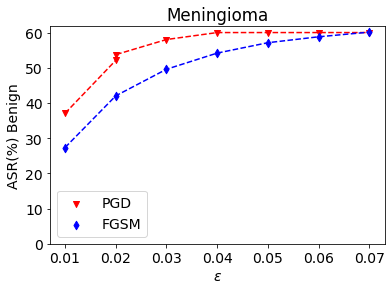

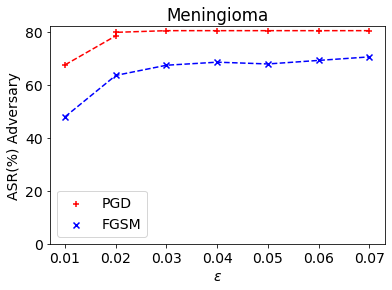

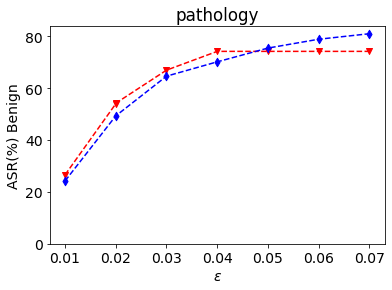

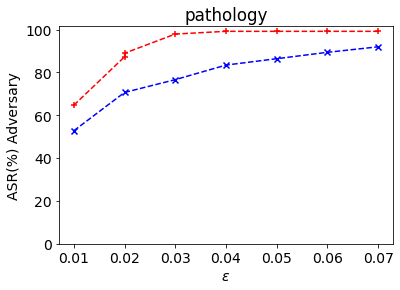

In [93]:
# Define the variables
dataset = "Glioma"  # Replace with the actual dataset name
cuda_device = 0  # Use 0 if you have only one GPU or specify the GPU index
metric = 'ASR'  # Choose from 'ASR', 'AATR', 'time', or 'alignment'
path,path_aatr,path_time = path_finder(dataset)
device = torch.device("cuda:{}".format(cuda_device))
 
plot_graphs_eps("Glioma",path)

path,path_aatr,path_time = path_finder("MRI")

plot_graphs_eps("MRI",path)
path,path_aatr,path_time = path_finder("Pathology")

plot_graphs_eps("pathology",path)
